# Pre-Processing

## Setup environment 

In [1]:
!pip install matplotlib numpy pandas
!pip install scipy sklearn
!pip install tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm # Loading progress

np.random.seed(0)

## Import Data

In [3]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [4]:
data_batch_1 = unpickle("data/data_batch_1")
data_batch_2 = unpickle("data/data_batch_2")
data_batch_3 = unpickle("data/data_batch_3")
data_batch_4 = unpickle("data/data_batch_4")
data_batch_5 = unpickle("data/data_batch_5")
test_batch = unpickle("data/test_batch")
batches = unpickle("data/batches.meta")

In [5]:
Y1 = np.array(data_batch_1[b"labels"])

X1 = np.array(data_batch_1[b"data"])

Normalization:

In [6]:
X1 = X1 - np.mean(X1)
X1 /= np.std(X1)

In [7]:
def show_image(image):
    pix = image.reshape(3, 1024).T.reshape(32, 32, 3)
    plt.imshow(pix)

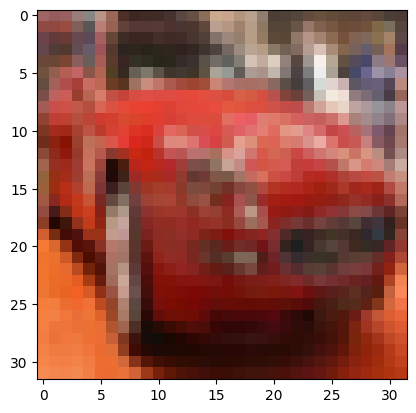

In [8]:
show_image(data_batch_1[b"data"][5])

In [9]:
batches.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [10]:
batches

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [11]:
batches[b"label_names"][0]

b'airplane'

In [12]:
labels = batches[b"label_names"]

In [13]:
print(f"X shape: {X1.shape}, " + f"Y shape: {Y1.shape}, " + f"{Y1}")

X shape: (10000, 3072), Y shape: (10000,), [6 9 9 ... 1 1 5]


**TO DO:**
1.   Vectorize
2.   Center
3.   Normalize


# OHE

In [14]:
def OHE(dataset):
    data_ohe = np.eye(10)[dataset]
    return data_ohe

In [15]:
Y1_ohe = OHE(Y1)
print(f"Y1: {Y1[:5]}, Y1_OHE: {Y1_ohe[:5]}")

Y1: [6 9 9 4 1], Y1_OHE: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


# MLP

## Layer

In [16]:
class Layer:
    def __init__(self, n_inputs, units):
        """
        Layer of neurons/units \n
        :param n_inputs: size of input that each unit receives
        :param units: number of units in layer
        """
        self.dinputs = None
        self.db = None
        self.dw = None
        self.inputs = None
        self.output = None
        # Initialize weights
        self.w = 0.01 * np.random.randn(n_inputs, units)
        self.b = np.zeros((1, units))

    def forward(self, inputs):
        """
        Perform a forward pass through the layer \n
        Saves result in output
        :param inputs: input to pass through units
        """
        self.inputs = inputs
        self.output = np.dot(inputs, self.w) + self.b

    def backward(self, dvals):
        """
        Perform a backward pass through the layer \n
        Saves the result in dinputs
        :param dvals: the incoming derivatives
        """
        # Gradients
        self.dw = np.dot(self.inputs.T, dvals)
        self.db = np.sum(dvals, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvals, self.w.T)
 

## Activation Functions

### ReLU

In [17]:
class ReLU:
    # Apply ReLU to inputs
    def __init__(self):
        """
        Rectified Linear Unit \n
        Activation function equivalent to max(0, input)
        """
        self.dinputs = None
        self.output = None
        self.inputs = None

    def forward(self, inputs):
        """
        Apply ReLU to inputs \n
        Saves inputs \n
        Saves result to output
        :param inputs: inputs
        """
        self.inputs = inputs
        # Apply ReLU
        self.output = np.maximum(0, inputs)

    def backward(self, dvals):
        """
        Calculate derivatives
        Saves result to dinputs \n
        :param dvals: incoming derivatives
        """
        self.dinputs = dvals.copy()
        # Derivative of ReLU
        self.dinputs[self.inputs <= 0] = 0

### Softmax

In [18]:
class Softmax:
    def __init__(self):
        """
        Softmax activation function for classification
        """
        self.dinputs = None
        self.output = None
        self.inputs = None

    def forward(self, inputs):
        """
        Apply softmax to inputs \n
        Saves result to output
        :param inputs: values to pass through softmax
        """
        self.inputs = inputs
        # Probabilities of each class
        exp = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        # Normalize probabilities between 0 and 1
        probs = exp / np.sum(exp, axis=1, keepdims=True)

        self.output = probs

    # Calculate derivatives to be able to pass them backwards
    def backward(self, dvals):
        """
        Calculate derivatives \n
        Saves result to dinputs
        :param dvals: incoming derivatives
        """
        self.dinputs = np.empty_like(dvals)

        # Enumerate outputs and gradients
        for index, (output, single_dvals) in enumerate(zip(self.output, dvals)):
            # Flatten
            output = output.reshape(-1, 1)
            # Jacobian
            jacob = np.diagflat(output) - np.dot(output, output.T)
            # calculate gradient and add to array
            self.dinputs[index] = np.dot(jacob, single_dvals)

## Gradient Descent

In [19]:
class SGD:
    def __init__(self, learning=0.01, decay=0.0):
        """
        Gradient descent (stochastic comes from outside this class)
        :param learning: learning_rate of algorithm
        :param decay: decay of learning_rate
        """
        self.learning_rate = learning
        self.current_learning_rate = learning
        self.decay = decay
        self.iterations = 0

    def apply_decay(self):
        """
        Decay learning rate
        """
        self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
        )

    def update(self, layer):
        """
        Update weights and biases of layer according to learning_rate
        :param layer: layer to update
        """

        delta_w = -self.current_learning_rate * layer.dw
        delta_b = -self.current_learning_rate * layer.db

        layer.w += delta_w
        layer.b += delta_b

    def post_update(self):
        self.iterations += 1

## Categorical Cross Entropy Loss

In [20]:
class CategoricalCrossEntropyLoss:
    def __init__(self):
        """
        Helper class for container that will have
        both loss and activation together
        """
        self.dinputs = None

    def calculate(self, output, y):
        """
        Calculates forward and the mean_loss compared to the actual values
        :param output: output of previous layer
        :param y: actual y values
        :return: mean loss of data
        """
        losses = self.forward(output, y)

        mean_loss = np.mean(losses)
        return mean_loss

    def forward(self, y_pred, y_true):
        """
        Passes the inputs forward through the loss function
        :param y_pred: predicted y values
        :param y_true: actual y values to compare to
        :return: negative log likelihood of each category
        """
        n_samples = len(y_pred)

        # clip values to avoid div by 0
        y_pred_clip = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # print(f'Top 5 y true {y_true[:5]}, Y true shape: {y_true.shape}')
        # print(f'Top 5 y pred {y_pred[:5]}, Y pred shape: {y_pred.shape}')
        # for categorical labels
        if len(y_true.shape) == 1:
            correct = y_pred_clip[range(n_samples), y_true]

        # for one-hot-encoded labels
        elif len(y_true.shape) == 2:
            correct = np.sum(y_pred_clip * y_true, axis=1)
        # Negative log likelihood
        return -np.log(correct)

    def backward(self, dvals, y_true):
        """
        Pass derivatives backwards through network
        :param dvals: input derivatives
        :param y_true: actual values
        """
        # print(f'Top 5 y true {y_true[:5]}, Y true shape: {y_true.shape}')

        n_samples = len(dvals)
        n_labels = len(dvals[0])

        # Turn into OHE vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # gradients
        self.dinputs = -y_true / dvals
        # norm grads
        self.dinputs = self.dinputs / n_samples

### Softmax + Cat loss helper

In [21]:
class SoftmaxAndCategoricalLoss:
    def __init__(self):
        """
        Merges softmax and the loss function to calculate them together
        """
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropyLoss()

    def forward(self, inputs, y_true):
        """
        Pass inputs through activation and calculate loss
        :param inputs: network inputs
        :param y_true: actual y values to calculate loss with
        :return: mean loss of data if y_true is not None
        """
        self.activation.forward(inputs)
        self.output = self.activation.output
        if y_true is not None:
            return self.loss.calculate(self.output, y_true)

    def backward(self, dvals, y_true):
        """
        Pass derivatives backward through network
        :param dvals: input derivatives
        :param y_true: actual values
        """
        n_samples = len(dvals)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvals.copy()
        # Grad
        self.dinputs[range(n_samples), y_true] -= 1
        # Norm
        self.dinputs = self.dinputs / n_samples

## MLP class

In [39]:
class MLP:
    def __init__(self, act_fun, num_hidden_layers, hid_layer_units, input_size,
                 output_size, optimizer, max_iters=10000, record_updates=False,
                 enable_mini_batch=True, batch_size=32):
        """
        Multi Layer Perceptron for image classification
        :param act_fun: activation function for hidden layers
        :param num_hidden_layers: number of hidden layers
        :param hid_layer_units: list of number of neurons/units per layer
        :param input_size: number of inputs expected
        :param output_size: size of output (num of classes for classification)
        :param optimizer: optimizer class to be used for gradient descent
        :param max_iters: maximum number of epochs to be run
        :param record_updates: whether to record loss and accuracy history
        :param enable_mini_batch: whether to use mini batches
        :param batch_size: size of batch to use
        """
        if num_hidden_layers != len(hid_layer_units):
            raise Exception(
                'Must provide list of units of size of hidden layers')

        self.max_iters = max_iters
        self.act_fun = act_fun
        self.hidden_layers = num_hidden_layers
        self.hid_layer_units = hid_layer_units
        self.input_size = input_size
        self.record_updates = record_updates
        if record_updates:
            self.loss_history = []
            self.accuracy_history = []

        self.enable_mini_batch = enable_mini_batch
        self.batch_size = batch_size

        # initialize MLP

        self.hid_layers = []
        self.hid_activations = []
        self.create_layers(hid_layer_units, num_hidden_layers, input_size,
                           output_size)

        self.optimizer = optimizer

    def create_layers(self, hid_layer_units, num_hidden_layers, input_size,
                      output_size):
        """
        Create layers of network
        :param hid_layer_units: list containing number of neurons per layer
        :param num_hidden_layers: number of layers
        :param input_size: size of input given to network
        :param output_size: size of output or number of classes
        """
        # Create hidden layers
        if num_hidden_layers >= 1:
            # First layer takes in input
            self.hid_layers.append(Layer(input_size, hid_layer_units[0]))
            self.hid_activations.append(self.act_fun())
            # Other layers take in input from previous layer and
            # we're starting creation at index 1 = (i + 1),
            # so input is i and number of neurons is i + 1
            for i in range(0, self.hidden_layers - 1):
                self.hid_layers.append(
                    Layer(hid_layer_units[i], hid_layer_units[i + 1]))
                self.hid_activations.append(self.act_fun())

            self.output_layer = Layer(hid_layer_units[-1], output_size)
            self.output_activation = SoftmaxAndCategoricalLoss()
        # Only create output layer
        else:
            self.output_layer = Layer(input_size, output_size)
            self.output_activation = SoftmaxAndCategoricalLoss()

    def fit(self, X, y):
        """
        Fit model to our data
        :param X: inputs to the model
        :param y: expected values of inputs
        """
        for epoch in tqdm(range(self.max_iters)):

            if self.enable_mini_batch:
                mini_batches = self.create_mini_batches(X, y)
                for mini_batch in mini_batches:
                    x_mini, y_mini = mini_batch[:, :X.shape[1]], mini_batch[:,
                                                                 X.shape[1]:]
                    accuracy, loss = self.train(x_mini, y_mini)
            else:
                accuracy, loss = self.train(X, y)

            if self.record_updates:
                self.loss_history.append(loss)
                self.accuracy_history.append(accuracy)

            if epoch < 5:
                self.print_info(accuracy, epoch + 1, loss)

        self.print_info(accuracy, self.max_iters, loss)

    def print_info(self, accuracy, epoch, loss):
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {self.optimizer.current_learning_rate}')

    # Train network on data
    def train(self, X, y):
        """
        Train network on data \n
        Perform a forward and backward pass through the network
        :param X: inputs to pass through network
        :param y: expected values of data
        :return: accuracy and loss of network on the data
        """
        loss = self.forward(X, y)
        accuracy = self.calculate_accuracy(y)

        self.backward(y)

        self.optimize()
        return accuracy, loss

    def optimize(self):
        """
        Run optimizer on all layers
        """
        self.optimizer.apply_decay()
        for layer in self.hid_layers:
            self.optimizer.update(layer)
        self.optimizer.update(self.output_layer)
        self.optimizer.post_update()

    def backward(self, y):
        """
        Perform backward pass through all layers
        :param y: expected value of data
        """
        self.output_activation.backward(self.output_activation.output,
                                        y)
        self.output_layer.backward(self.output_activation.dinputs)
        prev_input = self.output_layer.dinputs
        for layer, activation in zip(self.hid_layers[::-1],
                                     self.hid_activations[::-1]):
            activation.backward(prev_input)
            layer.backward(activation.dinputs)
            prev_input = layer.dinputs

    def forward(self, X, y):
        """
        Pass data through network and calculate loss and accuracy
        of network
        :param X: data to pass through network
        :param y: actual values of data
        :return: loss calculated by last layer of the network if y is not None
        """

        prev_X = X
        # Perform forward pass through all hidden layers
        for layer, activation in zip(self.hid_layers,
                                     self.hid_activations):
            layer.forward(prev_X)
            activation.forward(layer.output)
            prev_X = activation.output
        # Perform forward pass through output layer
        self.output_layer.forward(prev_X)
        loss = self.output_activation.forward(self.output_layer.output,
                                              y)
        return loss

    def calculate_accuracy(self, y):
        # predictions = np.argmax(self.output_layer.output, axis=1)
        # # if len(y.shape) == 2:
        # y_for_pred = np.argmax(y, axis=1)
        # accuracy = np.mean(predictions == y_for_pred)
        # return accuracy
        return self.evaluate_acc(y, self.output_layer.output)
    
    def evaluate_acc(self, y_true, y_pred):
        """
        Calculate accuracy
        
        """
        pred = np.argmax(y_pred, axis=1)
        true = np.argmax(y_true, axis=1)
        return np.mean(pred == true)

    def predict(self, X):
        """
        Pass input through network and predict y values
        :param X: input to the network
        :return: y predictions and loss
        """
        # TODO: figure out how to do this
        self.forward(X, None)
        return self.output_activation.output


    def create_mini_batches(self, X, y):
        """
        Create mini batches with data
        :param X: x values of data
        :param y: y values of data
        :return: mini batches of size self.batch_size
        """
        data = np.column_stack([X, y])
        np.random.shuffle(data)
        n_mini_batches = data.shape[0] // self.batch_size
        return np.array_split(data[:self.batch_size * n_mini_batches],
                              n_mini_batches)

# Run

## Instantiate MLP

In [40]:
optimizer = SGD(learning=0.1, decay=0.001)
mlp = MLP(
    ReLU, 2, [64, 64], 3072, 10, optimizer, max_iters=100, record_updates=True, enable_mini_batch=True, batch_size=16
)
mlp.fit(X1, Y1_ohe)

  1%|▊                                                                                 | 1/100 [00:01<02:19,  1.41s/it]

epoch: 1, acc: 0.500, loss: 1.417, lr: 0.06157635467980295


  2%|█▋                                                                                | 2/100 [00:02<02:18,  1.42s/it]

epoch: 2, acc: 0.562, loss: 1.598, lr: 0.044464206313917294


  3%|██▍                                                                               | 3/100 [00:04<02:16,  1.41s/it]

epoch: 3, acc: 0.375, loss: 1.873, lr: 0.03479471120389701


  4%|███▎                                                                              | 4/100 [00:05<02:15,  1.41s/it]

epoch: 4, acc: 0.750, loss: 1.119, lr: 0.02857959416976279


  5%|████                                                                              | 5/100 [00:07<02:14,  1.42s/it]

epoch: 5, acc: 0.625, loss: 1.086, lr: 0.02424830261881668


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]

epoch: 100, acc: 1.000, loss: 0.053, lr: 0.0015748279500464573


## Plotting

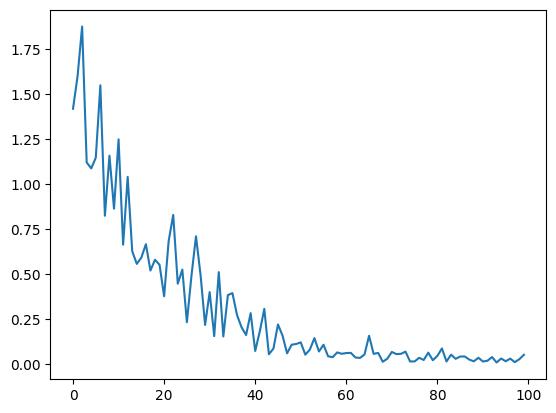

In [41]:
plt.plot(mlp.loss_history)

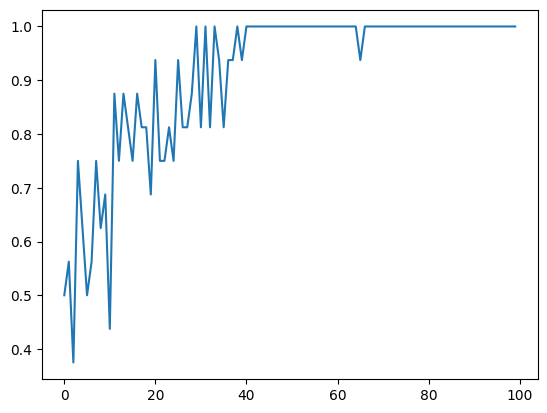

In [42]:
plt.plot(mlp.accuracy_history)

In [43]:
X1[0]
Y1_ohe[0]
mlp.predict(X1[0])

array([[2.83278811e-04, 1.26371062e-04, 1.21244678e-05, 1.85373756e-02,
        7.32624315e-04, 5.50368531e-05, 9.80225054e-01, 2.35358022e-05,
        3.61535617e-06, 9.83340461e-07]])

# Experiments

## Three Models

### No hidden Layers

In [58]:
optimizer_no_hid = SGD(learning=0.1, decay=0.001)
mlp_no_hid = MLP(
    ReLU, 0, [], 3072, 10, optimizer=optimizer_no_hid, max_iters=1000, record_updates=True, enable_mini_batch=True, batch_size=16
)
mlp_no_hid.fit(X1, Y1_ohe)

  0%|                                                                                 | 1/1000 [00:00<12:19,  1.35it/s]

epoch: 1, acc: 0.438, loss: 4.641, lr: 0.06157635467980295


  0%|▏                                                                                | 2/1000 [00:01<12:31,  1.33it/s]

epoch: 2, acc: 0.250, loss: 6.737, lr: 0.044464206313917294


  0%|▏                                                                                | 3/1000 [00:02<11:54,  1.40it/s]

epoch: 3, acc: 0.375, loss: 3.448, lr: 0.03479471120389701


  0%|▎                                                                                | 4/1000 [00:02<10:56,  1.52it/s]

epoch: 4, acc: 0.625, loss: 1.630, lr: 0.02857959416976279


  0%|▍                                                                                | 5/1000 [00:03<11:23,  1.46it/s]

epoch: 5, acc: 0.375, loss: 3.995, lr: 0.02424830261881668


  5%|███▉                                                                            | 49/1000 [00:31<10:10,  1.56it/s]


KeyboardInterrupt: 

### One hidden layer

In [ ]:
optimizer_one_hid = SGD(learning=0.1, decay=0.001)
mlp_one_hid = MLP(
    ReLU, 1, [256], 3072, 10, optimizer=optimizer_one_hid, max_iters=1000, record_updates=True, enable_mini_batch=True, batch_size=16
)
mlp_one_hid.fit(X1, Y1_ohe)

### Two hidden layers

In [ ]:
optimizer_two_hid = SGD(learning=0.1, decay=0.001)
mlp_two_hid = MLP(
    ReLU, 2, [256, 256], 3072, 10, optimizer=optimizer_two_hid, max_iters=1000, record_updates=True, enable_mini_batch=True, batch_size=16
)
mlp_two_hid.fit(X1, Y1_ohe)

In [ ]:
loss_histories = [mlp_no_hid.loss_history, mlp_one_hid.loss_history, mlp_two_hid.loss_history]
for hist in loss_histories:
    plt.plot(hist)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['0', '1', '2'], title='Number of hidden layers (256 units)')
plt.title('Loss over time for different MLPs')

In [ ]:
accuracy_histories = [mlp_no_hid.accuracy_history, mlp_one_hid.accuracy_history, mlp_two_hid.accuracy_history]
for hist in accuracy_histories:
    plt.plot(hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['0', '1', '2'], title='Number of hidden layers (256 units)')
plt.title('accuracy over time for different MLPs')

In [ ]:
optimizer_two_hid.iterations